## Clustering Jerárquico: Aproximación "aglomerativa" o bottom-up

Adaptado de https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/

### Problema de negocio y motivación

Supón que trabajamos en el equipo de análisis de datos e IA de una empresa y que vamos a colaborar con el departamento de marketing. El departamento de marketing ha estado recopilando datos de compras de clientes durante un tiempo, y quieren entender, basándose en los datos recopilados, si hay similitudes entre los clientes. Estas similitudes dividen a los clientes en grupos y tener grupos de clientes ayuda en el targeting de campañas, promociones, conversiones y en la construcción de mejores relaciones con los clientes.

Una forma de responder a esas preguntas es mediante el uso de un algoritmo de agrupamiento, como K-Means, DBSCAN como ya vimos, y también podríamos alicar clustering jerárquico. En términos generales, los algoritmos de agrupamiento encuentran similitudes entre puntos de datos y los agrupan.

En este caso, nuestros datos de marketing son bastante pequeños. Tenemos información sobre solo 200 clientes. Considerando al equipo de marketing, es importante que podamos explicar claramente cómo se tomaron las decisiones basadas en el número de grupos, explicándoles cómo funciona en realidad el algoritmo.

Dado que nuestros datos son pequeños y la explicabilidad es un factor importante, podemos aprovechar la Agrupación Jerárquica para resolver este problema. Este proceso también se conoce como Análisis de Agrupación Jerárquica.

**Una de las ventajas de la Agrupación Jerárquica es que es interpretable y funciona bien en conjuntos de datos pequeños.**

Otra cosa a tener en cuenta es que estamos trabajando con un problema de aprendizaje no supervisado. Al agrupar los datos, no tendremos una forma de verificar que estamos identificando correctamente que un usuario pertenece a un grupo específico (no conocemos los grupos). No hay etiquetas con las que comparar nuestros resultados. Si identificamos correctamente los grupos, el departamento de marketing lo confirmará más tarde en su día a día (según métricas como ROI, tasas de conversión, etc.).

Ahora que hemos entendido el problema que estamos tratando de resolver y cómo resolverlo, ¡podemos empezar a echar un vistazo a nuestros datos!

---

### Obtención de  datos

Antes de la obtención de datos vamos a cargar nuestras librerias con algún añadido

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
path_to_file = './data/shopping_data.csv'
customer_data = pd.read_csv(path_to_file)

Y como hacemos siempre, "echamos un vistazo"

In [4]:
customer_data.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Esta "limpito", pero no hay target. Primera cosa que no haremos: NO HAY SPLIT DE TRAIN Y TEST (porque no tiene sentido)

Pero eso no quiere decir que no hagamos explorción de datos para entenderlos mejor.

### Explorar datos (miniEDA)

Al no existir un target, el objetivo del miniEDA en un problema no supervisado no es ver la relación de las features con este para entender mejor las mismas, hacer selección y gestionar las expectativas de capacidad del modelo. Ahora:

1. Necesitamos ver si hay que escalar (y transformasr) las features numéricas, porque los algoritmos de agrupamiento o clustering utilizan distancias y, por tanto, son sensibles al escalado.
2. Necesitamos (en esto no cambia nada) codificar las variables categóricas que vayamos a usar y ver cómo eso afecta al escalado anterior (algo parecido a lo que pasaba con KNN en el que veíamos que puede ser mejor usar la normalización con MinMax que el estandarizado porque las variables categóricas se convierten en 1 y 0).
3. Podemos hacer feature selection si al visualizar de dos en dos o de tres en tres (más dimensiones es difícil contemplar) ya vemos algún posible agrupamiento. 

Vamos a hacer eso precisamente, pasaremos por los puntos 1 y 2 y terminaremos aplicando el 3 para decidir si usamos todas las features o con un subconjunto nos es suficiente.

#### Variables/features numéricas

Empezamos viendo las distribuciones y escalas:

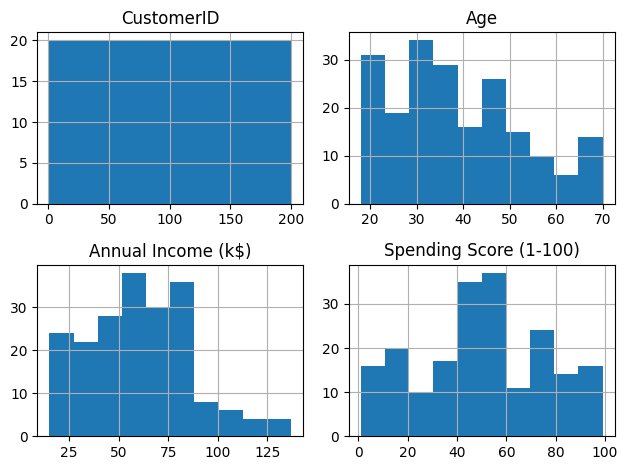

In [6]:
customer_data.hist()
plt.tight_layout()

In [7]:
customer_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


Aquí, vemos que el grupo marketing ha generado un CustomerID, que tiene 100% de cardinalidad o variabilidad (normal es un índice),una Edad entre 18 y 70, ingresos entre 15 y 137 (en miles de dolares) y un score o puntuaje de Gasto que va de 1 a 100 para cada uno de los 200 clientes. [NOTA: Cuando se les pidió aclaración, dijeron que los valores en la columna de Puntaje de Gasto significan con qué frecuencia una persona gasta dinero en un centro comercial en una escala del 1 al 100. En otras palabras, si un cliente tiene un puntaje de 0, esta persona nunca gasta dinero, y si el puntaje es 100, acabamos de encontrar al que más gasta]

Es decir en términos de escala podríamos incluso no hacer nada porque son escalas bastante similares, de hecho por simplicidad no vamos a escalar salvo que las variables categóricas al codificarlas nos lleven a ello. Eso sí viendo las distribuciones, ¿que feature tendríamos que transformar?    
  
Parece que Annual Income sería bueno aplicarle un logartimo o una raíz en caso de tener que escalar.

#### Variables/features categóricas

Tenemos una única variable categórica que es gender.

In [8]:
customer_data.Genre.value_counts(normalize = True)

Genre
Female    0.56
Male      0.44
Name: proportion, dtype: float64

Es binaria y directamente la pasamos a 0 y 1

In [9]:
customer_data["Genre"] = (customer_data["Genre"] == "Female").astype(int)

In [10]:
customer_data.Genre.value_counts(normalize = True)

Genre
1    0.56
0    0.44
Name: proportion, dtype: float64

En el caso de que nos quedemos Genre como feature tendríamos que escalar convenientemente las features numéricas anteriores, utilizando un MinMax para que todos los rangos estuvieran entre 0 y 1, por ejemplo. O bien  hacer los dos escalados y ver qué tal salen las clusterizaciones (ojo ese a ver qué tal quiere decir que valoraremos las clusterizacion desde un punto de vista "cualitativo" con Marketing). Aunque viendo las escalas también podríamos multiplicar Genre por 100. 

### Feature Selection

En general, meteríamos todas las features en el algoritmo escogido, pero antes conviene ver si utilizando 2 o 3 podemos encontrar ya potenciales clusters interesantes. Y eso vamos a hacer, en concreto vamos a ver los scatter plots y el plot de separación de Genre (porque es binaria) para ver si existe algún cluster interesante.

***

Empezamos de 2 en 2 con un pairplot (quitándonos ya el CustomerID)

In [11]:
train_set = customer_data.drop("CustomerID", axis = 1)

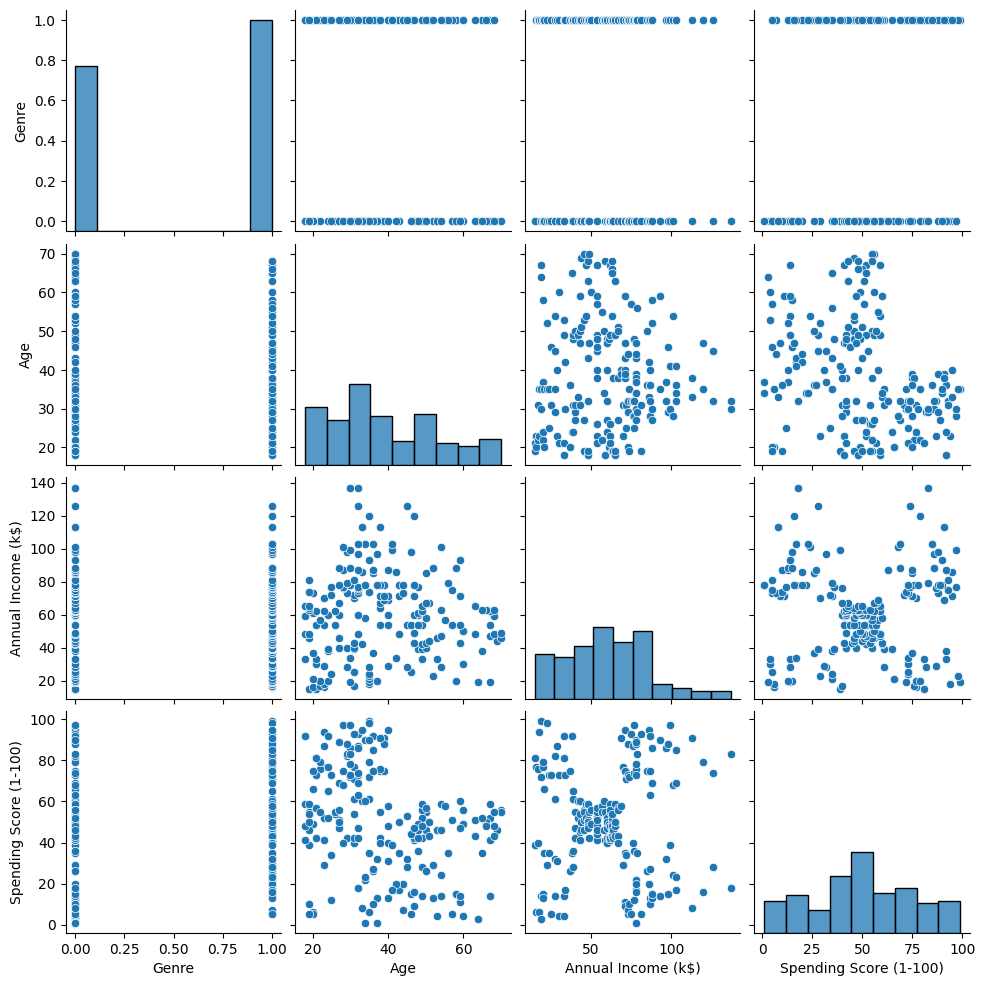

In [12]:
sns.pairplot(train_set) # Sin separar por Genre 

Fíjate que Annual Income y Spending Score ya forman algo parecido a unas agrupaciones. Antes de verlo con detalle, vamos a ver qué pasa con Genre (que de por si es una agrupación pero veamos si hay diferencia en las distribuciones del resto de variables). Usaremos pairplot pero sólo nos fiajremos en la diagonal y en el impacto en la correlación Annual Income y Spending Score por si añadiera info:

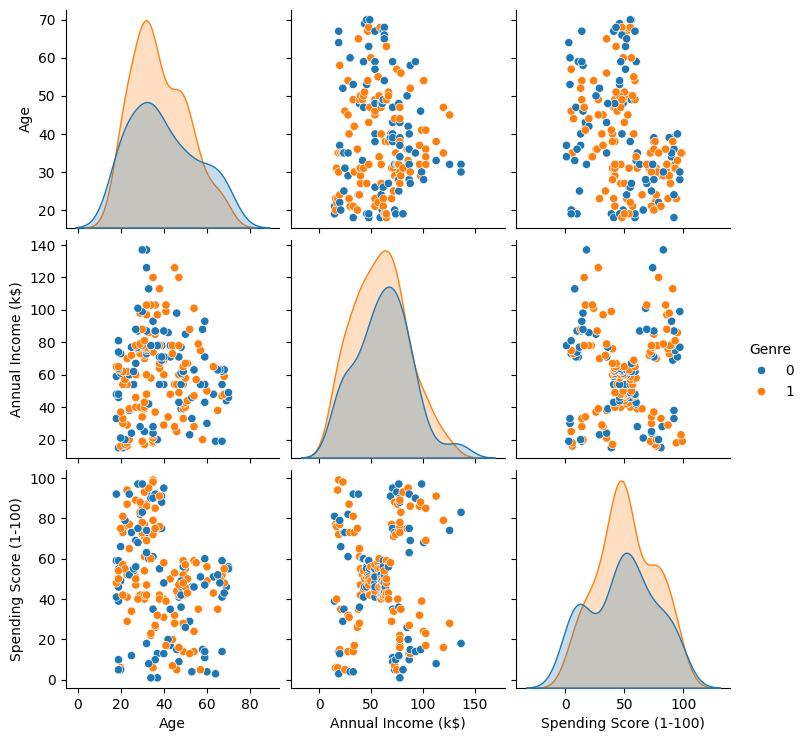

In [13]:
sns.pairplot(train_set, hue = "Genre") # Sin separar por Genre 

Ahora no se trata de ver si va a ser muy predictiva o no sino de si las distribuciones de las numéricas se separan visiblemente para un valor y otro de Genre (Que eso indicaría que ayudarían a un mejor agrupamiento) y lo cierto es que no hay una superposición completa pero sí que vemos que son bastante similares. Y además si te fijas en los gráficos de Annual Income vs Spending, tampoco aporta. En principio no usaríamos Genre y simplificaría el feature set a Annual Income y Spending Score.

Por eso lo vamos a mirar con más detenimiento:

<Axes: xlabel='Annual Income (k$)', ylabel='Spending Score (1-100)'>

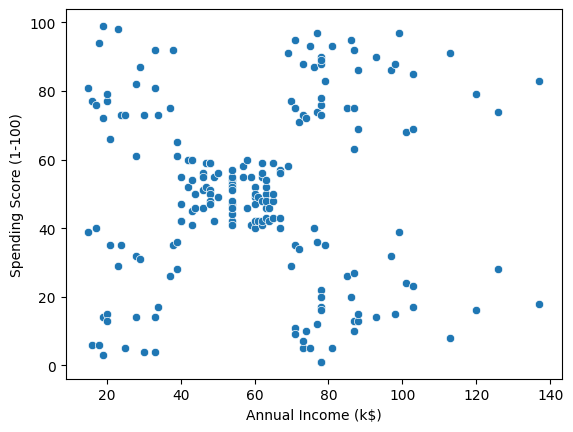

In [14]:
sns.scatterplot(x=customer_data['Annual Income (k$)'],
                y=customer_data['Spending Score (1-100)'])


Al observar más de cerca, definitivamente podemos distinguir 5 grupos diferentes de datos. Parece que nuestros clientes pueden ser agrupados basándose en cuánto ganan al año y cuánto gastan. Este es otro punto relevante en nuestro análisis. Es importante que estemos considerando solo dos características para agrupar a nuestros clientes. Cualquier otra información que tengamos sobre ellos no entra en la ecuación. Esto da significado al análisis: si sabemos cuánto gana y gasta un cliente, podemos encontrar fácilmente las similitudes que necesitamos.

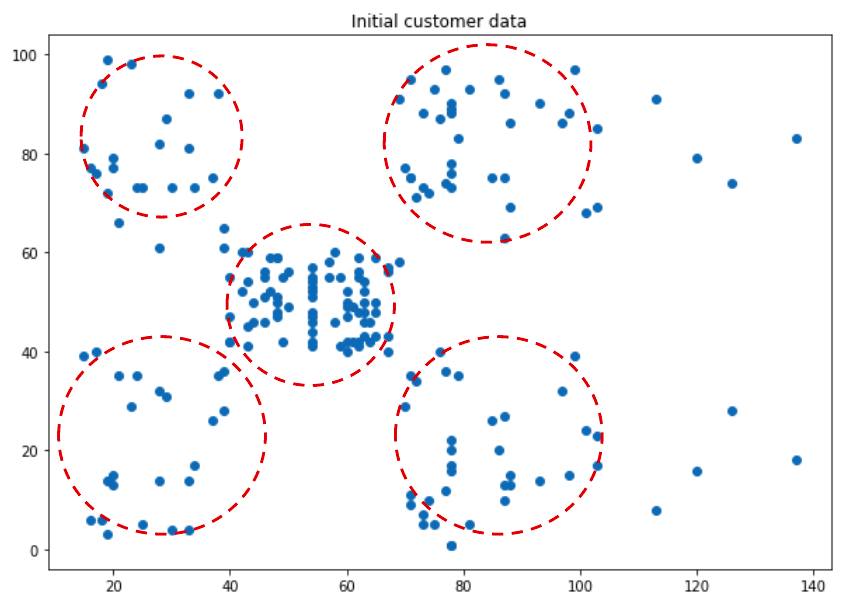

***

### Visualizando Estructura Jerárquica con Dendrogramas

### Understanding Hierarchical Clustering

Hasta ahora, hemos explorado los datos, codificado las columnas categóricas, decidido qué columnas eran adecuadas para el clustering y reducido la dimensionalidad de los datos. Los gráficos indican que tenemos 5 clusters en nuestros datos. Hasta ahí la forma "no jerarquica" de mirar el problema.   

Pero **también hay otra forma de visualizar las relaciones entre nuestros puntos y ayudar a determinar el número de clusters: creando un dendrograma** (comúnmente mal escrito como dendogram). Dendro significa árbol en latín.  

El dendrograma es el resultado del enlace de puntos en un conjunto de datos. Es una representación visual del proceso de clustering jerárquico. ¿Y cómo funciona el proceso de clustering jerárquico? Bueno... depende, probablemente una respuesta que ya has escuchado mucho en este bootcamp :-)

### Comprendiendo el Agrupamiento Jerárquico

Cuando el algoritmo de agrupamiento jerárquico (**HCA, Hierarchical Clustering Algorithm**) comienza a vincular los puntos y encontrar grupos, primero puede dividir los puntos en 2 grandes grupos, y luego dividir cada uno de esos dos grupos en grupos más pequeños, teniendo un total de 4 grupos, lo cual es el enfoque **divisivo** y de **arriba hacia abajo**.

Alternativamente, puede hacer lo contrario: puede mirar todos los puntos de datos, encontrar 2 puntos que estén más cercanos entre sí, vincularlos, y luego encontrar otros puntos que sean los más cercanos a esos puntos vinculados y seguir construyendo los 2 grupos desde **abajo hacia arriba**. Este es el enfoque **aglomerativo** que desarrollaremos.

### Pasos para realizar el agrupamiento jerárquico aglomerativo

Para hacer aún más claro el enfoque aglomerativo, hay pasos en el algoritmo de Clustering Jerárquico Aglomerativo (AHC):

    1. Al inicio, se trata cada punto de datos como un clúster. Por lo tanto, el número de clústeres al inicio será K, donde K es un número entero que representa el número de puntos de datos.
    2. Se forma un clúster uniendo los dos puntos de datos más cercanos, lo que resulta en K-1 clústeres.
    3. Se forman más clústeres uniendo los dos clústeres más cercanos, lo que resulta en K-2 clústeres.
    4. Se repiten los tres pasos anteriores hasta que se forme un único clúster grande.

Si inviertes los pasos del algoritmo ACH, yendo del 4 al 1 - esos serían los pasos para **Divisive Hierarchical Clustering (DHC)**

Otro punto importante es que se introduce el concepto de clústeres cercanos y lejanos, es decir tendremos que fijar una forma de evaluar cuando un clúster está más lejos o más cerca de otro. Es decir utilizar un concepto de distancia entre clústeres.

### Trazando y entendiendo el Dendrograma

Vamos a trazar el dendrograma de nuestros datos de clientes para visualizar las relaciones jerárquicas de los datos. Esta vez, usaremos la biblioteca scipy para crear el dendrograma de nuestro conjunto de datos:

In [15]:
customer_data.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,0,19,15,39
1,2,0,21,15,81
2,3,1,20,16,6
3,4,1,23,16,77
4,5,1,31,17,40


In [16]:
customer_data.columns

Index(['CustomerID', 'Genre', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

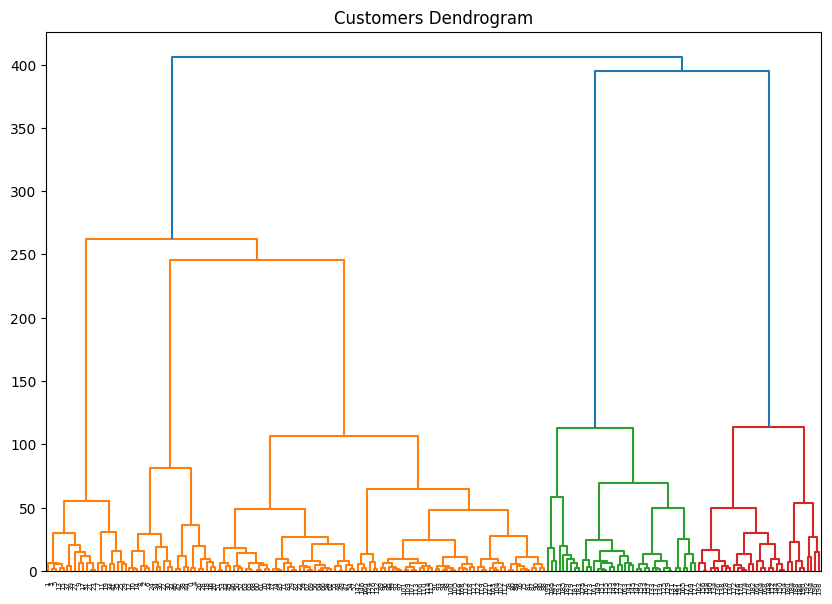

In [17]:
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.title("Customers Dendrogram")

selected_data = customer_data[["Annual Income (k$)","Spending Score (1-100)"]]
clusters = shc.linkage(selected_data, 
            method='ward', # Este hiperparámetro y el siguiente tienen que ver con la distancia entre clústeres y los veremos un poco más adelante
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()

En el script anterior, hemos generado los clústeres y subclústeres con nuestros puntos, definido cómo se conectarían nuestros puntos (aplicando el método ward), y cómo medir la distancia entre los puntos (usando la métrica euclidiana).

Para leer el dendrograma, hay que tener en cuenta que la "y" representa la distancia en los términos que se le haya dado al método `linkage` (en este caso ward, euclidean) de los diferentes clusters. Si trazamos una línea horizontal nos dice cuántos clústers hay a una distancia igual o superior. Así cortamos por el 0, todos los puntos son clusters. Si cortamos por un valor determinado de distancia se generarán tantos clusters como línea horizontales queden por debajo o líneas individuales. Si cortamos en la figura de arriba por y (distancia) = 250, quedarán 4 clústers:

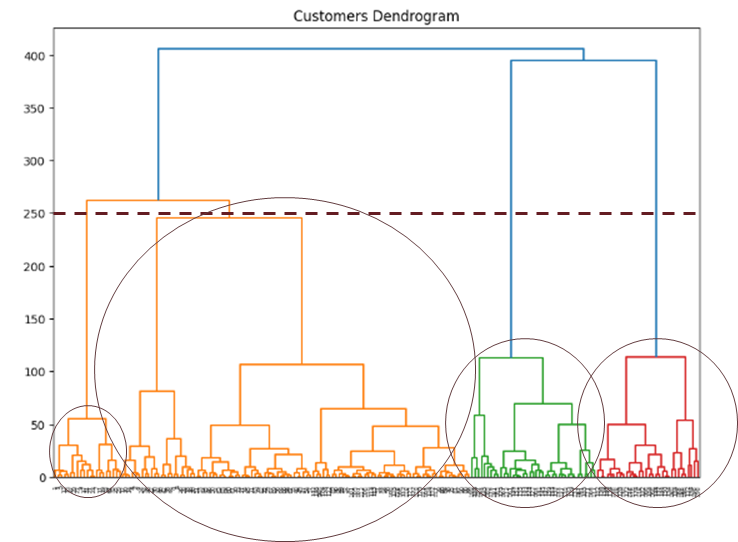

Es por es que lo métodos de vinculación (definidos por los argumentos que le damos al método linkage) son fundamentales en un clustering jerárquico.

***

### Métodos de vinculación (Linkage Methods)

Hay muchos métodos de enlace, al entender más sobre cómo funcionan, podrás elegir el apropiado para tus necesidades. Además, cada uno de ellos dará diferentes resultados cuando se apliquen. No hay una regla fija en el análisis de agrupamiento, si es posible, estudia la naturaleza del problema para ver cuál se ajusta mejor, prueba diferentes métodos e inspecciona los resultados.

Algunos de los métodos de enlace son:

   '

**Vínculo simple/Simple Linkage:** también conocido como vecino más cercano (NN). La distancia entre los clústeres se define por la distancia entre sus miembros más cercanos.
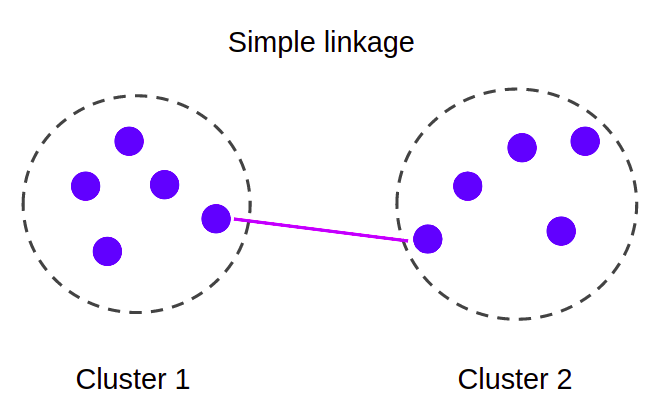

**Enlace completo/Complete Linkage:** también conocido como Vecino más lejano (FN), Algoritmo del punto más lejano, o Algoritmo Voor Hees. La distancia entre los clústeres se define por la distancia entre sus miembros más lejanos. Este método es computacionalmente costoso.
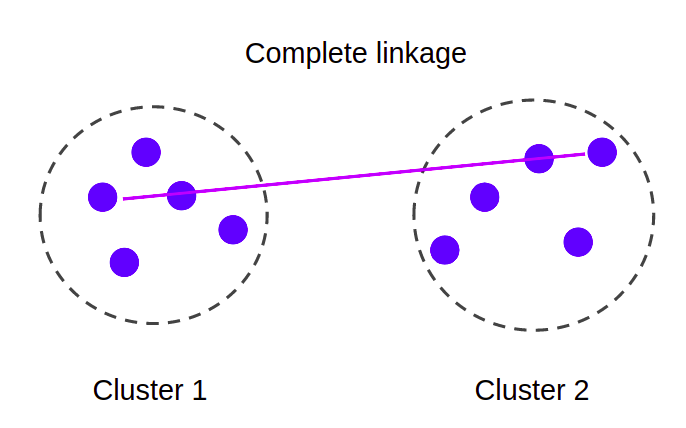

**Enlace promedio/Average Linkage:** también conocido como UPGMA (Método de Agrupamiento de Pares no Ponderado con Media Aritmética). Se calcula el porcentaje de puntos de cada grupo con respecto al número de puntos de los dos grupos si se fusionaran.
   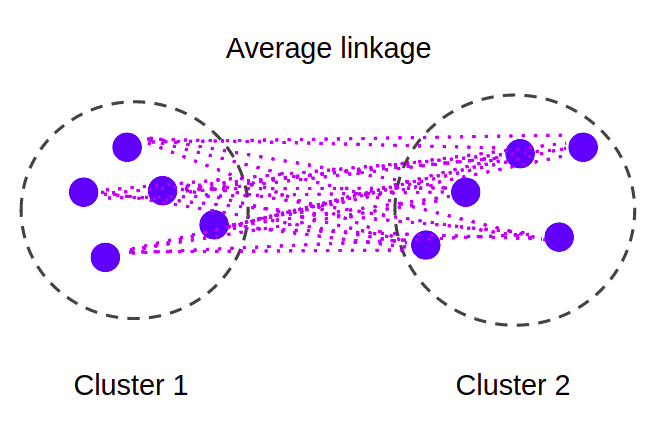

**Enlace del centroide/centroid linkage:** también conocido como UPGMC (Método de Grupo de Pares no Ponderado utilizando Centroides). Se calcula un punto definido por la media de todos los puntos (centroide) para cada clúster y la distancia entre clústeres es la distancia entre sus respectivos centroides.
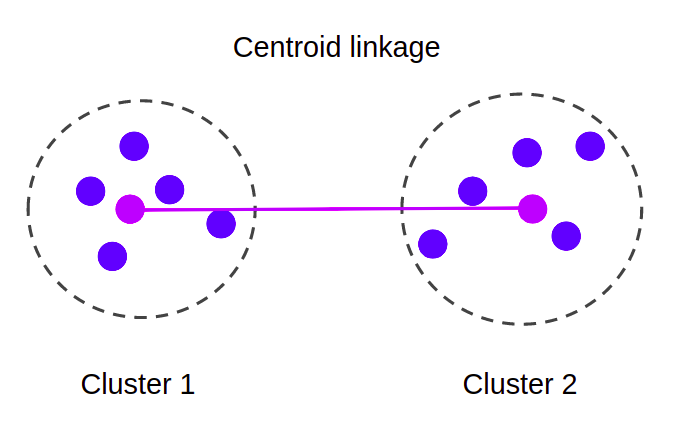

**Enlace de Ward/Ward Linkage:** También conocido como MISSQ (Minimal Increase of Sum-of-Squares). Especifica la distancia entre dos clústeres, calcula el error de la suma de cuadrados (ESS) y elige sucesivamente los siguientes clústeres en función del ESS más pequeño. El Método de Ward busca minimizar el aumento de ESS en cada paso. Por lo tanto, minimizando el error.
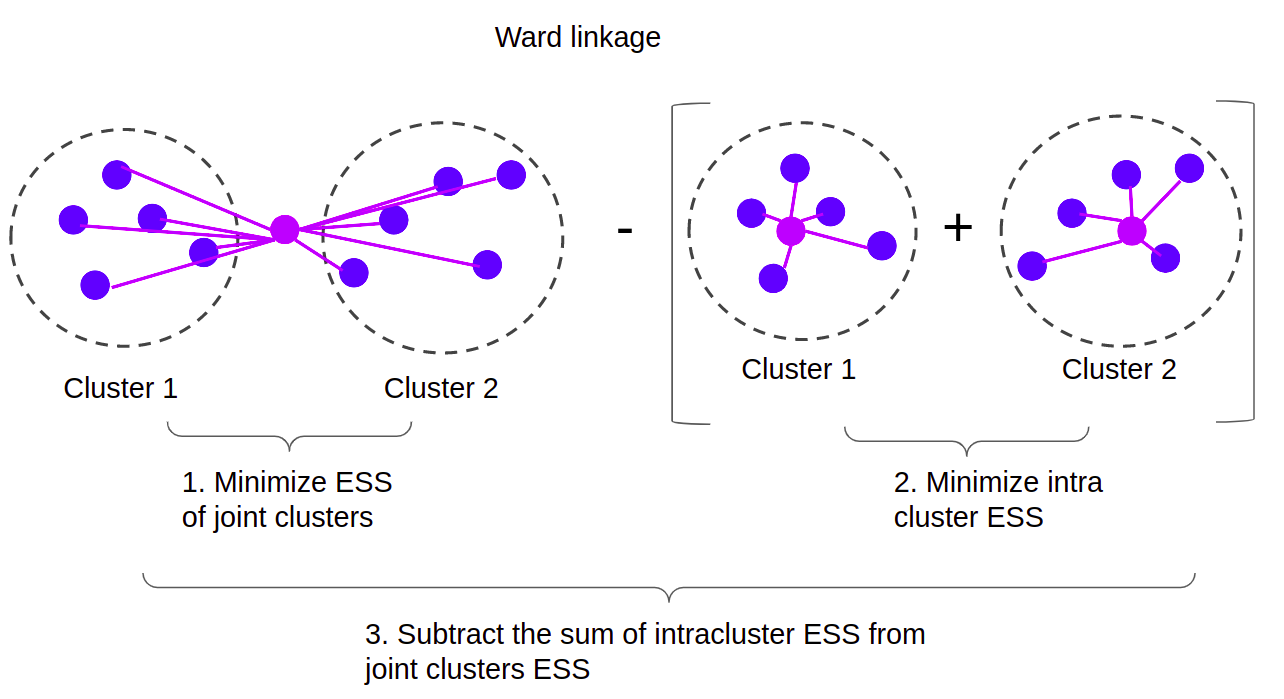

En cuanto a la **distancia**, también existen varias opciones (Euclidiana, Manhattan, Minkowski, Chebyshev, Coseno, Jaccard, etc).

Hemos elegido Ward y Euclidiana para el dendrograma porque son el método y métrica más comúnmente usados. Por lo general, dan buenos resultados ya que Ward enlaza puntos minimizando errores, y Euclidiana funciona bien con poca dimensionalidad.

En este ejemplo, estamos trabajando con dos características (columnas) de los datos de marketing, y 200 observaciones o filas. Dado que el número de observaciones es mayor que el número de características (200 > 2), estamos trabajando en un espacio de baja dimensión.

***

### Selección de K a partir del dendrograma

Ya hemos discutido métricas, enlaces y cómo cada uno de ellos puede impactar en nuestros resultados. Ahora continuemos con el análisis del dendrograma y veamos cómo puede darnos una indicación del número de clústeres en nuestro conjunto de datos.

Encontrar un número interesante de clústeres en un dendrograma es un pequeño arte con varios métodos posibles de aproximación. Nostros vamos a aplicar el denominado **método del mayor salto (gap)**. Consiste en buscar el espacio horizontal más grande (este es el mayor gap) que no tiene líneas verticales (el espacio con las líneas verticales más largas). 

Podemos trazar una línea horizontal que pase a través de esa distancia más larga:

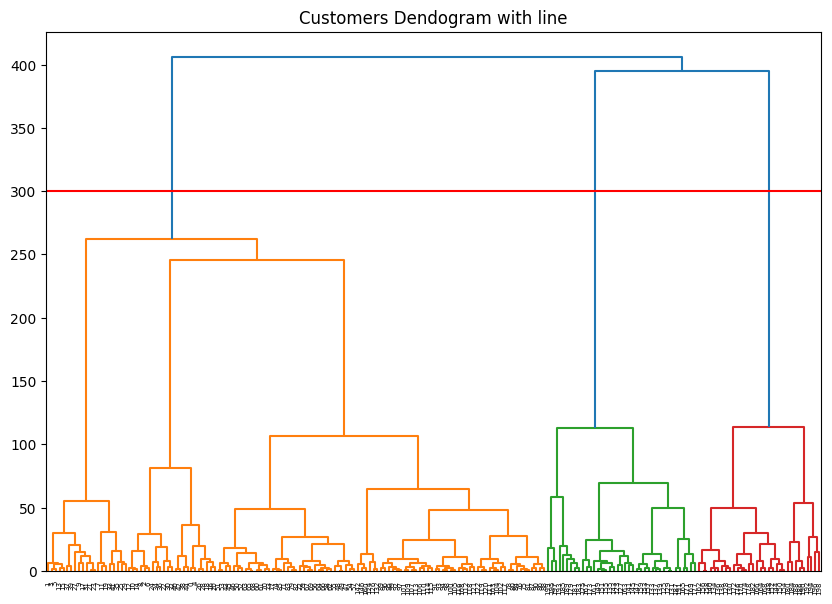

In [18]:
plt.figure(figsize=(10, 7))
plt.title("Customers Dendogram with line")
clusters = shc.linkage(selected_data, 
            method='ward', 
            metric="euclidean")
shc.dendrogram(clusters)
plt.axhline(y = 300, color = 'r', linestyle = '-')

Después de ubicar la línea horizontal, contamos cuántas veces nuestras líneas verticales fueron cruzadas por ella; en este ejemplo, 3 veces. Así que 3 parece una buena indicación del número de agrupaciones que tienen la mayor distancia entre ellas.  

Pero siempre podemos complementar el análisis con el que vimos del scatter plot de nuestras dos features, y comprobar para 5 clusters que distancia hay entre clusters y si nos parece adecuada entonces nos podemos saltar el mecanismo anterior:


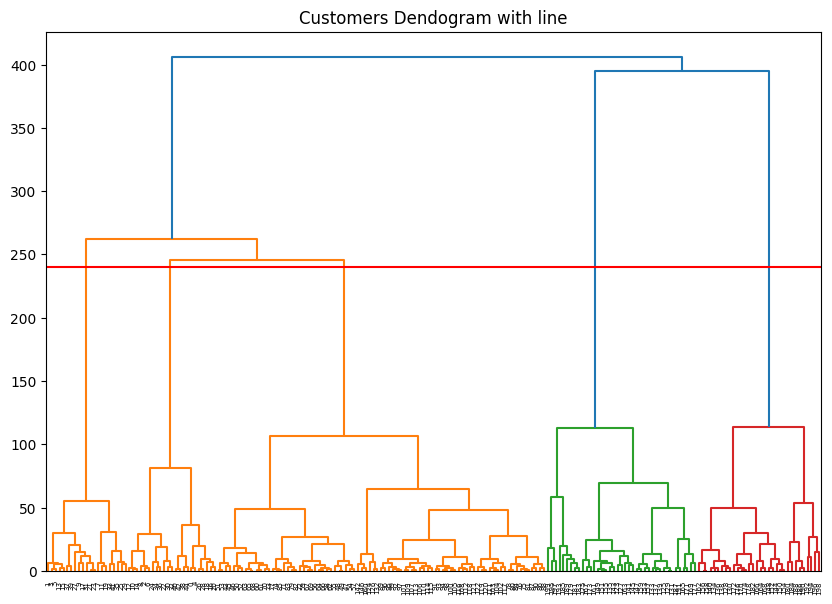

In [19]:
plt.figure(figsize=(10, 7))
plt.title("Customers Dendogram with line")
clusters = shc.linkage(selected_data, 
            method='ward', 
            metric="euclidean")
shc.dendrogram(clusters)
plt.axhline(y = 240, color = 'r', linestyle = '-')

Y no parece mala, no tiene tanto gap como 3 clústeres pero se les ve razonablemente separados.

**Nota: El dendrograma solo debería considerarse como una referencia al elegir el número de clusters. Puede desviarse fácilmente de ese número y está completamente influenciado por el tipo de enlace y métricas de distancia. Al realizar un análisis detallado de clusters, se recomienda observar dendrogramas con diferentes enlaces y métricas, y observar los resultados generados con las primeras tres líneas en las cuales los clusters tienen la mayor distancia entre ellos.**

***

### Implementando un Clustering Jerárquico Aglomerativo

Hasta ahora hemos calculado el número sugerido de clústeres para nuestro conjunto de datos que corroboran con nuestro análisis inicial. Este paso la elección de k o de los hiperparámetros se adelante en este proceso al proceso con datasets supervisados.

Ahora podemos crear nuestro modelo de agrupamiento jerárquico aglomerativo utilizando AgglomerativeClustering de Scikit-Learn y averiguar las etiquetas de los puntos de marketing con labels_:

In [20]:
from sklearn.cluster import AgglomerativeClustering

clustering_model = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')
clustering_model.fit(selected_data)
clustering_model.labels_

array([4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 1,
       4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 0, 2, 0, 2,
       1, 2, 0, 2, 0, 2, 0, 2, 0, 2, 1, 2, 0, 2, 1, 2, 0, 2, 0, 2, 0, 2,
       0, 2, 0, 2, 0, 2, 1, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 2])

Text(0.5, 1.0, 'Labeled Customer Data')

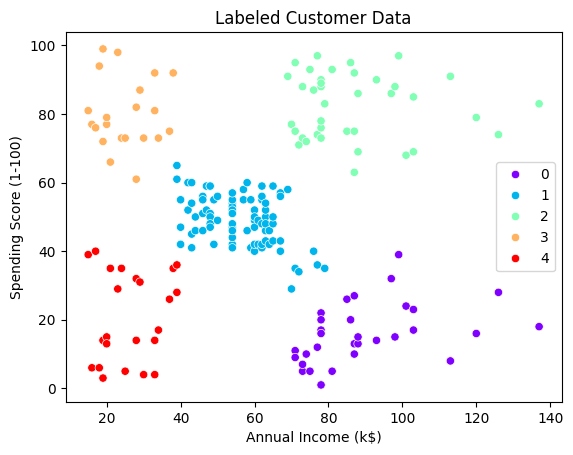

In [21]:
data_labels = clustering_model.labels_
sns.scatterplot(x='Annual Income (k$)', 
                y='Spending Score (1-100)', 
                data=selected_data, 
                hue=data_labels, palette = "rainbow").set_title('Labeled Customer Data')


Este es nuestro conjunto de datos final clusterizado. Puedes ver los puntos de datos codificados por colores en forma de cinco grupos.

Los puntos de datos en la esquina inferior derecha (etiqueta: 0, puntos de datos morados) pertenecen a los clientes con salarios altos pero bajos gastos. Estos son los clientes que gastan su dinero cuidadosamente.

De manera similar, los clientes en la esquina superior derecha (etiqueta: 2, puntos de datos verdes) son aquellos con salarios altos y altos gastos. Estos son el tipo de clientes a los que las empresas apuntan.

Los clientes en el medio (etiqueta: 1, puntos de datos azules) son aquellos con ingresos y gastos promedio. El mayor número de clientes pertenece a esta categoría. Las empresas también pueden apuntar a estos clientes dado el hecho de que son numerosos.

Los clientes en la esquina inferior izquierda (etiqueta: 4, rojo) son aquellos que tienen salarios bajos y bajos gastos, podrían ser atraídos ofreciéndoles promociones.

Y finalmente, los clientes en la esquina superior izquierda (etiqueta: 3, puntos de datos naranjas) son aquellos con gastos altos e ingresos bajos, que quizá son los clientes que deberíamos evitar.



### Ventajas del agrupamiento jerárquico: Cuándo usarlo y cuándo no

   - **Obtención de observaciones más similares a cualquier observación dada:** El principal beneficio del agrupamiento jerárquico es que proporciona información detallada sobre qué observaciones son más similares entre sí. Este nivel de detalle no es proporcionado por muchos otros algoritmos, que generalmente solo devuelven el ID del clúster al que pertenece una observación dada. El agrupamiento jerárquico es particularmente útil en situaciones en las que tienes algunas observaciones en las que estás particularmente interesado y deseas poder identificar observaciones similares a esas observaciones.
   
   - **Poco sensible a condiciones de inicialización:** Otro beneficio del agrupamiento jerárquico es que no es sensible a condiciones de inicialización, como semillas establecidas o el orden del conjunto de datos. Generalmente obtendrás resultados muy similares, y en algunos casos el mismo resultado exacto, si vuelves a ejecutar tu análisis con diferentes condiciones de inicialización.
   
   - **Puede adaptarse para incorporar variables categóricas:** Otro beneficio del agrupamiento jerárquico es que se puede adaptar para admitir situaciones donde tienes una mezcla de variables numéricas y categóricas relativamente fácilmente. Para hacer esto, debes asegurarte de que estás utilizando una métrica de distancia apropiada para tipos de datos mixtos, como la distancia de Grower.
    
   - **Bien estudiado:** Después del agrupamiento k-means, el agrupamiento jerárquico es probablemente el segundo tipo de algoritmo de agrupamiento más popular y bien estudiado. Eso significa que más de tus compañeros de trabajo estarán familiarizados con él, lo que hará más fácil para ellos entender y contribuir a los análisis que utilizan el agrupamiento jerárquico.
   
   - **Menos sensible a valores atípicos:** El agrupamiento jerárquico es menos sensible a valores atípicos que algunos otros algoritmos de agrupamiento. Esto significa que la presencia de unos pocos valores atípicos probablemente no afectará la forma en que el algoritmo funciona en los otros puntos de datos. Esto se debe a que generalmente los valores atípicos no se agregan a un clúster hasta el final del proceso, cuando todas las demás observaciones ya han sido manejadas (al menos para el agrupamiento jerárquico aglomerativo).
   
   - **Menos supuestos estrictos sobre la forma de los clústeres:** Los algoritmos de agrupamiento jerárquico no hacen supuestos tan estrictos sobre la forma de tus clústeres. Dependiendo de la métrica de distancia que uses, algunas formas de clústeres pueden detectarse más fácilmente que otras, pero hay más flexibilidad.

### Desventajas del agrupamiento jerárquico

   - **Lento:** Una desventaja del agrupamiento jerárquico es que es relativamente lento. Generalmente requiere el cálculo de la distancia entre todas las observaciones en tu conjunto de datos, por lo que el número de cálculos requeridos crece rápidamente a medida que aumenta el tamaño de tu conjunto de datos.